<a href="https://colab.research.google.com/github/oshbocker/CAFA/blob/main/CAFA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"oshbocker","key":"bb9c6a60ba5c39e689d8cf8d15cb8bca"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install obonet -q
!pip install biopython -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 12.5 MB/s eta 0:00:00


In [3]:
import os
import torch

from pathlib import Path


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

cafa_main_path = Path("cafa-5-protein-function-prediction")
cafa_clean_fasta_path = Path("viktorfairuschin/cafa-5-fasta-files")
esm2_path = Path("viktorfairuschin/cafa-5-ems-2-embeddings-numpy")
protbert_path = Path("henriupton/protbert-embeddings-for-cafa5")
t5_path = Path("sergeifironov/t5embeds")

data_paths = [cafa_clean_fasta_path, esm2_path, protbert_path, t5_path]

if iskaggle:
  content_dir = "/kaggle/input"
else:
  content_dir = "/content"

class CFG:
    train_go_obo_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = f"{content_dir}/cafa-5-protein-function-prediction/IA.txt"
    test_sequences_path: str = f"{content_dir}/Test (Targets)/testsuperset.fasta"

    num_labels = 500
    n_epochs = 14
    batch_size = 128
    lr = 0.0005

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
if not iskaggle:
  import zipfile,kaggle
  if not cafa_main_path.exists():
    print(cafa_main_path)
    kaggle.api.competition_download_cli(str(cafa_main_path))
    zipfile.ZipFile(f'{cafa_main_path}.zip').extractall(cafa_main_path)
  for data_path in data_paths:
    if not data_path.exists():
      print(data_path)
      kaggle.api.dataset_download_files(str(data_path))
      zipfile.ZipFile(f'{data_path.name}.zip').extractall(data_path.name)

cafa-5-protein-function-prediction


100%|██████████| 115M/115M [00:06<00:00, 19.2MB/s]



viktorfairuschin/cafa-5-fasta-files
viktorfairuschin/cafa-5-ems-2-embeddings-numpy
henriupton/protbert-embeddings-for-cafa5
sergeifironov/t5embeds


In [5]:
import obonet
import time

import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [6]:
graph = obonet.read_obo(CFG.train_go_obo_path)

In [7]:
# Information Accretion values for terms
ia_dict = {}
with open(CFG.train_ia_path) as f:
    for line in f:
        (key, value) = line.split("\t")
        ia_dict[key] = float(value.replace("\n",""))

In [8]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

BPO_len = len(nx.ancestors(graph, subontology_roots['BPO']))
CCO_len = len(nx.ancestors(graph, subontology_roots['CCO']))
MFO_len = len(nx.ancestors(graph, subontology_roots['MFO']))
print(BPO_len, CCO_len, MFO_len, BPO_len + CCO_len + MFO_len)

27941 4042 11262 43245


In [9]:
train_terms = pd.read_csv(CFG.train_terms_path, sep="\t")
train_terms['ia'] = train_terms['term'].apply(lambda x: ia_dict[x])
print(train_terms.shape)
train_terms.head(5)

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A009IHW8,GO:0034655,BPO,0.042274
2,A0A009IHW8,GO:0072523,BPO,0.083901
3,A0A009IHW8,GO:0044270,BPO,0.281155
4,A0A009IHW8,GO:0006753,BPO,0.013844


## Get the leaf predictions for each protein
A leaf prediction is a GO term that doesn't have any children that are also predictions for the protein.

In [10]:
def get_leaf_labels(train_terms, aspect):
    # Group by protein and get a list of all go term predictions
    protein_list_go_term = train_terms[train_terms['aspect'] == aspect].groupby('EntryID')['term'].apply(list)

    leaf_labels = {}
    for i, protein in enumerate(protein_list_go_term.index):
        test_terms = set(protein_list_go_term[protein])
        descendants = set()
        for term in test_terms:
            descendants.update(nx.descendants(graph, term))

        specific_labels = test_terms.difference(descendants)
        leaf_labels[protein] = list(specific_labels)

    return leaf_labels

from collections import deque

# Get ordered list of all ancestors
def leaf_label_ancestors(graph, leaf_labels):
    ordered_edges_dict = {}
    for label in leaf_labels:
        # Get ancestors
        ordered_edges = deque()
        node_is_root = False
        prev_node_id = label
        while node_is_root == False:
            node = graph.nodes[prev_node_id]
            node_is_root = 'is_a' not in node
            if not node_is_root:
                prev_node_id = node['is_a'][0]
                ordered_edges.appendleft(prev_node_id)
        ordered_edges_dict[label] = ordered_edges

    return ordered_edges_dict

In [11]:
def get_next_label(rw, depth=1):
    if not rw['labeled'] and len(rw['ordered_edges']) > depth:
        return rw['ordered_edges'][-depth]
    else:
        return rw['balanced_label']

def is_final_balanced_label(rw, balanced_labels, depth=1):
    if not rw['labeled']:
        return (rw['balanced_label'] in balanced_labels) or (len(rw['ordered_edges']) == depth)
    else:
        return True

def get_balanced_labels(label_df, label_count_threshold):
    df = label_df.copy()
    balanced_labels = set([label for label, count in df['label'].value_counts().items()
                           if count >= label_count_threshold])
    df['labeled'] = df['label'].apply(lambda x: x in balanced_labels)
    df['balanced_label'] = df['label'] # df.apply(lambda x: x['label'] if x['labeled'] == True else None, axis=1)
    print(sum(df['labeled'])/df.shape[0])
    print(len(balanced_labels))
    print(df['balanced_label'].value_counts())
    depth = 1
    while sum(df['labeled'])/df.shape[0] < 1:
        df['balanced_label'] = df.apply(lambda x: get_next_label(x, depth=depth), axis=1)
        balanced_labels = set([label for label, count in df['balanced_label'].value_counts().items()
                                   if count >= label_count_threshold])
        df['labeled'] = df.apply(lambda x: is_final_balanced_label(x, balanced_labels, depth=depth), axis=1)
        depth += 1
        print(sum(df['labeled'])/df.shape[0])
        print(len(balanced_labels))
        print(df['balanced_label'].value_counts())

    return df, df['balanced_label'].nunique() - 1

### Cellular Component Labels (CCO)

In [12]:
CCO_leaf_labels = get_leaf_labels(train_terms, 'CCO')
print("leaf_labels: ", len(CCO_leaf_labels.values()))
CCO_all_leaf_labels = np.unique(np.concatenate(list(CCO_leaf_labels.values())))
print("unique leaf_labels: ", len(CCO_all_leaf_labels))
CCO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'cellular_component']
CCO_ordered_edges = leaf_label_ancestors(graph, CCO_nodes)

# Get the first node label
CCO_data_with_labels = []
# Get all CCO labeled proteins with leaf labels
for protein, label_list in CCO_leaf_labels.items():
    for label in label_list:
        CCO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': CCO_ordered_edges[label]})

CCO_df = pd.DataFrame(CCO_data_with_labels)

new_CCO_df, CCO_num_labels = get_balanced_labels(CCO_df, 100)

leaf_labels:  92912
unique leaf_labels:  2763
0.8165753796709142
223
GO:0005829    16981
GO:0005634    12661
GO:0005886    11509
GO:0005737     8335
GO:0005654     8160
              ...  
GO:0097181        1
GO:0036029        1
GO:0036028        1
GO:0061834        1
GO:0071202        1
Name: balanced_label, Length: 2763, dtype: int64
0.9376060928411379
269
GO:0005829    16981
GO:0005634    12725
GO:0005886    11619
GO:0005737     8406
GO:0005654     8160
              ...  
GO:0035449        1
GO:0031002        1
GO:0030929        1
GO:0044292        1
GO:0098539        1
Name: balanced_label, Length: 771, dtype: int64
0.9815370164995586
278
GO:0005829    17050
GO:0005634    12784
GO:0005886    11619
GO:0005737     8418
GO:0005654     8160
              ...  
GO:0032994        1
GO:1990077        1
GO:0043659        1
GO:0033176        1
GO:0015935        1
Name: balanced_label, Length: 416, dtype: int64
0.9952753321413214
278
GO:0005829    17050
GO:0005634    12812
GO:0005886    116

1507

## Molecular Function Labels (MFO)

In [13]:
MFO_leaf_labels = get_leaf_labels(train_terms, 'MFO')
print("leaf labels: ", len(MFO_leaf_labels.values()))
MFO_all_leaf_labels = np.unique(np.concatenate(list(MFO_leaf_labels.values())))
print("unique leaf labels: ", len(MFO_all_leaf_labels))
MFO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'molecular_function']
MFO_ordered_edges = leaf_label_ancestors(graph, MFO_nodes)

# Get the first node label
MFO_data_with_labels = []
# Get all MFO labeled proteins with leaf labels
for protein, label_list in MFO_leaf_labels.items():
  # proteins with only protein binding GO:0005515 bias the dataset
  if label_list != ['GO:0005515']:
    for label in label_list:
        MFO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': MFO_ordered_edges[label]})

MFO_df = pd.DataFrame(MFO_data_with_labels)

new_MFO_df, MFO_num_labels = get_balanced_labels(MFO_df, 100)

leaf labels:  78637
unique leaf labels:  6866
0.5058240505218841
134
GO:0005515    11529
GO:0042802     3998
GO:0042803     1632
GO:0003729     1491
GO:0003723     1356
              ...  
GO:0016517        1
GO:0043875        1
GO:0052916        1
GO:0033094        1
GO:0102628        1
Name: balanced_label, Length: 6866, dtype: int64
0.7761161301640207
244
GO:0005515    13471
GO:0042802     3998
GO:0003723     1679
GO:0042803     1632
GO:0003729     1605
              ...  
GO:0018835        1
GO:0052713        1
GO:0052816        1
GO:0004908        1
GO:0050485        1
Name: balanced_label, Length: 1577, dtype: int64
0.9279712305938076
277
GO:0005515    14197
GO:0042802     3998
GO:0003723     2002
GO:0042803     1632
GO:0003729     1605
              ...  
GO:0000268        1
GO:0001882        1
GO:0120013        1
GO:0015459        1
GO:0016409        1
Name: balanced_label, Length: 661, dtype: int64
0.9790456977458117
280
GO:0005515    14576
GO:0042802     3998
GO:0003723     2

## Biological Process Labels (BPO)

In [14]:
BPO_leaf_labels = get_leaf_labels(train_terms, 'BPO')
print("leaf_labels: ", len(BPO_leaf_labels.values()))
BPO_all_leaf_labels = np.unique(np.concatenate(list(BPO_leaf_labels.values())))
print("unique leaf_labels: ", len(BPO_all_leaf_labels))
BPO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'biological_process']
BPO_ordered_edges = leaf_label_ancestors(graph, BPO_nodes)

# Get the first node label
BPO_data_with_labels = []
# Get all BPO labeled proteins with leaf labels
for protein, label_list in BPO_leaf_labels.items():
    for label in label_list:
        BPO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': BPO_ordered_edges[label]})

BPO_df = pd.DataFrame(BPO_data_with_labels)

new_BPO_df, BPO_num_labels = get_balanced_labels(BPO_df, 100)

leaf_labels:  92210
unique leaf_labels:  17978
0.35320886814469077
506
GO:0045944    2473
GO:0000122    1691
GO:0006355    1322
GO:0045893    1233
GO:0045892    1150
              ... 
GO:0061440       1
GO:0052337       1
GO:0090414       1
GO:0061716       1
GO:0009709       1
Name: balanced_label, Length: 17978, dtype: int64
0.6623570595099183
813
GO:0045944    2615
GO:0048856    1945
GO:0003006    1910
GO:0000122    1720
GO:0006355    1476
              ... 
GO:0090085       1
GO:0014046       1
GO:0070673       1
GO:0072020       1
GO:0046813       1
Name: balanced_label, Length: 6608, dtype: int64
0.8597532922153692
902
GO:0045944    2627
GO:0003006    2499
GO:0048856    2415
GO:0000122    1725
GO:0006355    1662
              ... 
GO:0033081       1
GO:0110112       1
GO:0033120       1
GO:0006551       1
GO:0019062       1
Name: balanced_label, Length: 3019, dtype: int64
0.9499516586097683
923
GO:0003006    2675
GO:0045944    2627
GO:0048856    2544
GO:0030154    1766
GO:000635

## Classify selected nodes of CCO

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def get_labels_df(balanced_label_df):
  ohe_df = pd.get_dummies(balanced_label_df, prefix=['balanced_label'], columns=['balanced_label'], drop_first=True)
  label_cols = [c for c in ohe_df.columns if 'balanced_label_' in c]
  label_df = ohe_df.groupby('protein').sum(numeric_only=True)[label_cols].clip(0,1)
  label_values = list(label_df.values)
  label_ids = list(label_df.index)
  labels_df = pd.DataFrame(data={"EntryID": label_ids, "labels_vect": label_values})
  return labels_df, label_cols

CCO_labels_df, CCO_label_cols = get_labels_df(new_CCO_df)
MFO_labels_df, MFO_label_cols = get_labels_df(new_MFO_df)
BPO_labels_df, BPO_label_cols = get_labels_df(new_BPO_df)
# Split into train, val, test
# X_train, X_test, y_train, y_test = train_test_split(label_ids,
#                                                     label_values,
#                                                     test_size = 0.2)
# print("Train label", len(y_train))
# print("Test label", len(y_test))

In [17]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "ESM2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280,
    "Concat": 1280+1024,
}

In [18]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source, subontology):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        self.subontology = subontology

        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "T5":
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "Concat":
            bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
            bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
            esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
            esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
            t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
            t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")
            esm2_sorted_ids, esm2_sorted_embeds = map(list,zip(*list(sorted(zip(esm2_ids, esm2_embeds), key=lambda x: x[0]))))
            t5_sorted_ids, t5_sorted_embeds = map(list,zip(*list(sorted(zip(t5_ids, t5_embeds), key=lambda x: x[0]))))
            # t5 includes the same embedding twic
            if datatype == "test":
              del t5_sorted_ids[632]
              del t5_sorted_embeds[632]
            embeds = np.concatenate([esm2_sorted_embeds, t5_sorted_embeds], axis=1)
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": t5_sorted_ids, "embed" : embeds_list})
        else:
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})

        if datatype=="train":
          if subontology=="CCO":
              self.df = self.df.merge(CCO_labels_df, on="EntryID")
          if subontology=="MFO":
              self.df = self.df.merge(MFO_labels_df, on="EntryID")
          if subontology=="BPO":
              self.df = self.df.merge(BPO_labels_df, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [19]:
datatype = "test"
bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")

In [20]:
esm2_sorted_ids, esm2_sorted_embeds = map(list,zip(*list(sorted(zip(esm2_ids, esm2_embeds), key=lambda x: x[0]))))
t5_sorted_ids, t5_sorted_embeds = map(list,zip(*list(sorted(zip(t5_ids, t5_embeds), key=lambda x: x[0]))))

In [21]:
print(len(esm2_sorted_ids))
print(len(t5_sorted_ids))

141864
141865


In [22]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes, p):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 4*1012)
        self.activation1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p)
        self.linear2 = torch.nn.Linear(4*1012, 4*712)
        self.activation2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(p)
        self.linear3 = torch.nn.Linear(4*712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
def train_model(embeddings_source, subontology, num_labels, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source, subontology=subontology)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=CFG.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=num_labels, p=0.2).to(CFG.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=num_labels).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=num_labels).to(CFG.device)
    n_epochs = CFG.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [24]:
# cat_CCO_model, cat_CCO_losses, cat_CCO_scores = train_model(embeddings_source="Concat", subontology="CCO", num_labels=CCO_num_labels, model_type="linear")

In [25]:
# esm2_model, esm2_losses, esm2_scores = train_model(embeddings_source="ESM2",model_type="linear")

In [26]:
# Weighted F1 Score?

In [27]:
t5_CCO_model, t5_CCO_losses, t5_CCO_scores = train_model(embeddings_source="T5", subontology="CCO", num_labels=CCO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:16<00:00, 39.88it/s]


Running Average TRAIN Loss :  6.902996109895385
Running Average TRAIN F1-Score :  0.041174722631783754
Running Average VAL Loss :  6.358826415179527
Running Average VAL F1-Score :  0.055186531468205256


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 47.09it/s]


Running Average TRAIN Loss :  6.185797756965007
Running Average TRAIN F1-Score :  0.061957471944186666
Running Average VAL Loss :  6.098087892140428
Running Average VAL F1-Score :  0.06373786819103645


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 47.06it/s]


Running Average TRAIN Loss :  5.894040561232727
Running Average TRAIN F1-Score :  0.0715419538603919
Running Average VAL Loss :  5.958570513006759
Running Average VAL F1-Score :  0.07358227736533504


EPOCH  4


100%|██████████| 654/654 [00:14<00:00, 46.62it/s]


Running Average TRAIN Loss :  5.65810020618847
Running Average TRAIN F1-Score :  0.08023605674550803
Running Average VAL Loss :  5.812639099277862
Running Average VAL F1-Score :  0.07768505265655583


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 47.52it/s]


Running Average TRAIN Loss :  5.447869076276773
Running Average TRAIN F1-Score :  0.08886911602126896
Running Average VAL Loss :  5.727527030526775
Running Average VAL F1-Score :  0.08385829520348


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 47.19it/s]


Running Average TRAIN Loss :  5.243254599221256
Running Average TRAIN F1-Score :  0.09819698920444976
Running Average VAL Loss :  5.678382233397602
Running Average VAL F1-Score :  0.09086475250859784


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 47.17it/s]


Running Average TRAIN Loss :  5.0458183751558305
Running Average TRAIN F1-Score :  0.107166935817911
Running Average VAL Loss :  5.63272482728305
Running Average VAL F1-Score :  0.09781138935725983


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 46.76it/s]


Running Average TRAIN Loss :  4.863542418232022
Running Average TRAIN F1-Score :  0.11651790858636574
Running Average VAL Loss :  5.640378364144939
Running Average VAL F1-Score :  0.10081568380741224


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 48.17it/s]


Running Average TRAIN Loss :  4.687268025284514
Running Average TRAIN F1-Score :  0.1258637902614538
Running Average VAL Loss :  5.629239898838409
Running Average VAL F1-Score :  0.10587826524287054


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 47.28it/s]


Running Average TRAIN Loss :  4.520434300833886
Running Average TRAIN F1-Score :  0.134711476333371
Running Average VAL Loss :  5.642500132730563
Running Average VAL F1-Score :  0.10965921219489345


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 47.91it/s]


Running Average TRAIN Loss :  4.365308065662326
Running Average TRAIN F1-Score :  0.1430981539941709
Running Average VAL Loss :  5.674004848689249
Running Average VAL F1-Score :  0.11437718172187675


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 47.50it/s]


Running Average TRAIN Loss :  3.9935022599835643
Running Average TRAIN F1-Score :  0.15556632194223755
Running Average VAL Loss :  5.619399096867809
Running Average VAL F1-Score :  0.11862486549844481


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 47.48it/s]


Running Average TRAIN Loss :  3.907098831386741
Running Average TRAIN F1-Score :  0.15951662740758435
Running Average VAL Loss :  5.622978197385187
Running Average VAL F1-Score :  0.1188411119661919


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 47.19it/s]


Running Average TRAIN Loss :  3.8689152239294957
Running Average TRAIN F1-Score :  0.163114361351054
Running Average VAL Loss :  5.644911067126548
Running Average VAL F1-Score :  0.12001790402278509


TRAINING FINISHED
FINAL TRAINING SCORE :  0.163114361351054
FINAL VALIDATION SCORE :  0.12001790402278509


In [28]:
# protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")

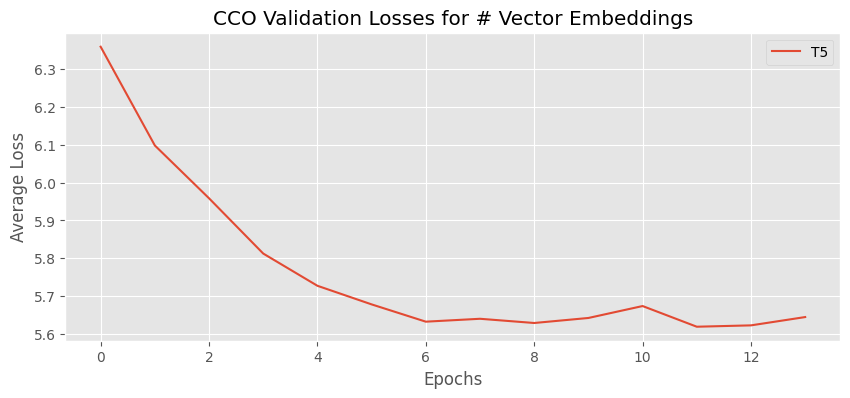

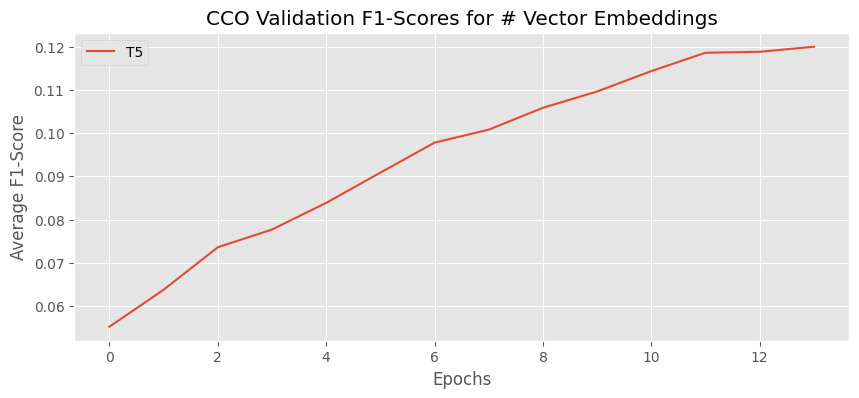

In [29]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_CCO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_CCO_losses["val"], label = "Concat")
plt.title("CCO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_CCO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_CCO_scores["val"], label = "Concat")
plt.title("CCO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [30]:
# cat_MFO_model, cat_MFO_losses, cat_MFO_scores = train_model(embeddings_source="Concat", subontology="MFO", num_labels=MFO_num_labels, model_type="linear")

In [31]:
t5_MFO_model, t5_MFO_losses, t5_MFO_scores = train_model(embeddings_source="T5", subontology="MFO", num_labels=MFO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 422/422 [00:09<00:00, 46.59it/s]


Running Average TRAIN Loss :  7.113402104490741
Running Average TRAIN F1-Score :  0.0474144769324899
Running Average VAL Loss :  6.057100569948237
Running Average VAL F1-Score :  0.07240149394628849


EPOCH  2


100%|██████████| 422/422 [00:08<00:00, 46.94it/s]


Running Average TRAIN Loss :  5.801928587999389
Running Average TRAIN F1-Score :  0.08280797848274922
Running Average VAL Loss :  5.59601228795153
Running Average VAL F1-Score :  0.08700679781589102


EPOCH  3


100%|██████████| 422/422 [00:09<00:00, 46.85it/s]


Running Average TRAIN Loss :  5.380890914049194
Running Average TRAIN F1-Score :  0.0975490526574271
Running Average VAL Loss :  5.385889966437158
Running Average VAL F1-Score :  0.09740795638967067


EPOCH  4


100%|██████████| 422/422 [00:09<00:00, 45.98it/s]


Running Average TRAIN Loss :  5.101480871580224
Running Average TRAIN F1-Score :  0.10861658793101661
Running Average VAL Loss :  5.211063932865224
Running Average VAL F1-Score :  0.10834970832505125


EPOCH  5


100%|██████████| 422/422 [00:09<00:00, 46.52it/s]


Running Average TRAIN Loss :  4.8667559437277195
Running Average TRAIN F1-Score :  0.11885187304380099
Running Average VAL Loss :  5.11909318984823
Running Average VAL F1-Score :  0.11648646884776176


EPOCH  6


100%|██████████| 422/422 [00:09<00:00, 45.85it/s]


Running Average TRAIN Loss :  4.665064913401672
Running Average TRAIN F1-Score :  0.12920352923396922
Running Average VAL Loss :  5.046002667000953
Running Average VAL F1-Score :  0.12356004055510177


EPOCH  7


100%|██████████| 422/422 [00:08<00:00, 46.90it/s]


Running Average TRAIN Loss :  4.497523355822993
Running Average TRAIN F1-Score :  0.1392598067767812
Running Average VAL Loss :  4.988160833399347
Running Average VAL F1-Score :  0.13383394321228595


EPOCH  8


100%|██████████| 422/422 [00:08<00:00, 47.15it/s]


Running Average TRAIN Loss :  4.3166813805204995
Running Average TRAIN F1-Score :  0.14926224230166296
Running Average VAL Loss :  4.958195564594675
Running Average VAL F1-Score :  0.1378009853527901


EPOCH  9


100%|██████████| 422/422 [00:09<00:00, 46.18it/s]


Running Average TRAIN Loss :  4.16768873585344
Running Average TRAIN F1-Score :  0.15909549420019745
Running Average VAL Loss :  4.939807212099116
Running Average VAL F1-Score :  0.14336849796645185


EPOCH  10


100%|██████████| 422/422 [00:09<00:00, 46.45it/s]


Running Average TRAIN Loss :  4.024569202938351
Running Average TRAIN F1-Score :  0.16746276200382632
Running Average VAL Loss :  4.915141739743821
Running Average VAL F1-Score :  0.15177814884388702


EPOCH  11


100%|██████████| 422/422 [00:09<00:00, 46.63it/s]


Running Average TRAIN Loss :  3.874582502514265
Running Average TRAIN F1-Score :  0.17705845168981507
Running Average VAL Loss :  4.886481224222386
Running Average VAL F1-Score :  0.15931051113504044


EPOCH  12


100%|██████████| 422/422 [00:09<00:00, 46.53it/s]


Running Average TRAIN Loss :  3.74861408579406
Running Average TRAIN F1-Score :  0.18493850771072917
Running Average VAL Loss :  4.912688671274388
Running Average VAL F1-Score :  0.1603242780299897


EPOCH  13


100%|██████████| 422/422 [00:09<00:00, 46.39it/s]


Running Average TRAIN Loss :  3.634926087200924
Running Average TRAIN F1-Score :  0.19218352252520374
Running Average VAL Loss :  4.931332973723716
Running Average VAL F1-Score :  0.16433612780368073


EPOCH  14


100%|██████████| 422/422 [00:08<00:00, 47.19it/s]


Running Average TRAIN Loss :  3.3209636205745534
Running Average TRAIN F1-Score :  0.201332649419093
Running Average VAL Loss :  4.885223764054318
Running Average VAL F1-Score :  0.17208992293540468


TRAINING FINISHED
FINAL TRAINING SCORE :  0.201332649419093
FINAL VALIDATION SCORE :  0.17208992293540468


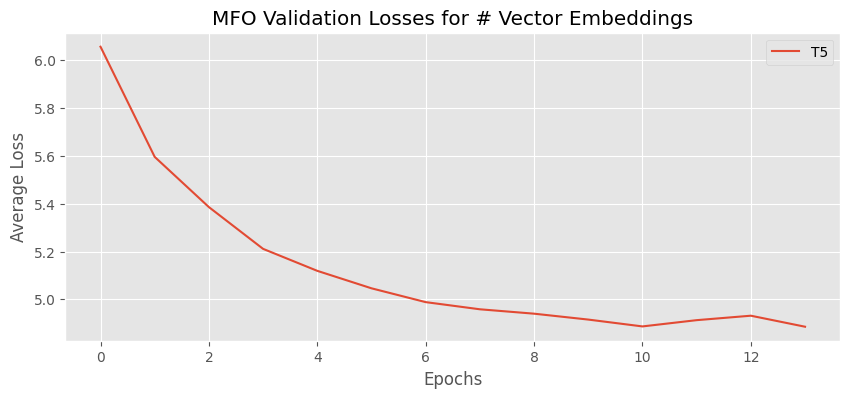

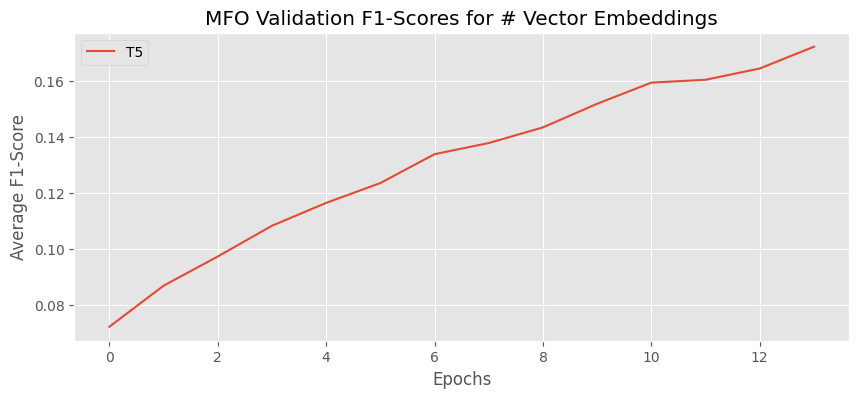

In [32]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_MFO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_MFO_losses["val"], label = "Concat")
plt.title("MFO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_MFO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_MFO_scores["val"], label = "Concat")
plt.title("MFO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [33]:
# cat_BPO_model, cat_BPO_losses, cat_BPO_scores = train_model(embeddings_source="Concat", subontology="BPO", num_labels=BPO_num_labels, model_type="linear")

In [34]:
t5_BPO_model, t5_BPO_losses, t5_BPO_scores = train_model(embeddings_source="T5", subontology="BPO", num_labels=BPO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 649/649 [00:14<00:00, 43.28it/s]


Running Average TRAIN Loss :  18.163478141573066
Running Average TRAIN F1-Score :  0.024052095378480725
Running Average VAL Loss :  17.298325185906396
Running Average VAL F1-Score :  0.035124238197730015


EPOCH  2


100%|██████████| 649/649 [00:14<00:00, 43.76it/s]


Running Average TRAIN Loss :  16.746754906394266
Running Average TRAIN F1-Score :  0.04304420184028351
Running Average VAL Loss :  16.51650373249838
Running Average VAL F1-Score :  0.04530682402969121


EPOCH  3


100%|██████████| 649/649 [00:14<00:00, 43.29it/s]


Running Average TRAIN Loss :  16.036378598911185
Running Average TRAIN F1-Score :  0.05364754825015373
Running Average VAL Loss :  16.285191810294375
Running Average VAL F1-Score :  0.05282236351185057


EPOCH  4


100%|██████████| 649/649 [00:14<00:00, 44.21it/s]


Running Average TRAIN Loss :  15.437742221520752
Running Average TRAIN F1-Score :  0.06260005604814399
Running Average VAL Loss :  16.018440664631047
Running Average VAL F1-Score :  0.05902243414511011


EPOCH  5


100%|██████████| 649/649 [00:14<00:00, 43.76it/s]


Running Average TRAIN Loss :  14.89582357568256
Running Average TRAIN F1-Score :  0.07253282750240643
Running Average VAL Loss :  16.024245614874854
Running Average VAL F1-Score :  0.06516689896481494


EPOCH  6


100%|██████████| 649/649 [00:14<00:00, 43.86it/s]


Running Average TRAIN Loss :  14.401646818328528
Running Average TRAIN F1-Score :  0.08114366605877876
Running Average VAL Loss :  16.08842981678166
Running Average VAL F1-Score :  0.07054389300054476


EPOCH  7


100%|██████████| 649/649 [00:14<00:00, 43.34it/s]


Running Average TRAIN Loss :  13.596150968401751
Running Average TRAIN F1-Score :  0.09305764249137076
Running Average VAL Loss :  15.58650084717633
Running Average VAL F1-Score :  0.07415582877520012


EPOCH  8


100%|██████████| 649/649 [00:14<00:00, 43.47it/s]


Running Average TRAIN Loss :  13.448712260770872
Running Average TRAIN F1-Score :  0.09614953623714359
Running Average VAL Loss :  15.684826197689526
Running Average VAL F1-Score :  0.0754610009950726


EPOCH  9


100%|██████████| 649/649 [00:14<00:00, 44.27it/s]


Running Average TRAIN Loss :  13.365544802602525
Running Average TRAIN F1-Score :  0.09772069483582155
Running Average VAL Loss :  15.505732066010776
Running Average VAL F1-Score :  0.07560834995381636


EPOCH  10


100%|██████████| 649/649 [00:15<00:00, 43.24it/s]


Running Average TRAIN Loss :  13.287724954872543
Running Average TRAIN F1-Score :  0.09929335910040535
Running Average VAL Loss :  15.532371364227712
Running Average VAL F1-Score :  0.07625790365831289


EPOCH  11


100%|██████████| 649/649 [00:14<00:00, 43.91it/s]


Running Average TRAIN Loss :  13.22230632793738
Running Average TRAIN F1-Score :  0.10045620353063009
Running Average VAL Loss :  15.567090530918069
Running Average VAL F1-Score :  0.07657817701413615


EPOCH  12


100%|██████████| 649/649 [00:14<00:00, 43.56it/s]


Running Average TRAIN Loss :  13.125622877170933
Running Average TRAIN F1-Score :  0.1019263433404439
Running Average VAL Loss :  15.55551528930664
Running Average VAL F1-Score :  0.07693134597821595


EPOCH  13


100%|██████████| 649/649 [00:15<00:00, 42.42it/s]


Running Average TRAIN Loss :  13.111668939399426
Running Average TRAIN F1-Score :  0.10231180436828838
Running Average VAL Loss :  15.627405218882103
Running Average VAL F1-Score :  0.07610016157978201


EPOCH  14


100%|██████████| 649/649 [00:15<00:00, 41.99it/s]


Running Average TRAIN Loss :  13.107440031548311
Running Average TRAIN F1-Score :  0.10245743909354202
Running Average VAL Loss :  15.466886637962027
Running Average VAL F1-Score :  0.077004337198522


TRAINING FINISHED
FINAL TRAINING SCORE :  0.10245743909354202
FINAL VALIDATION SCORE :  0.077004337198522


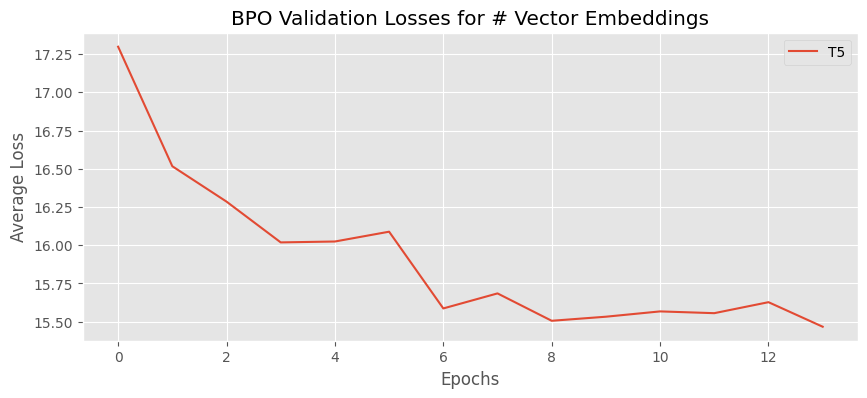

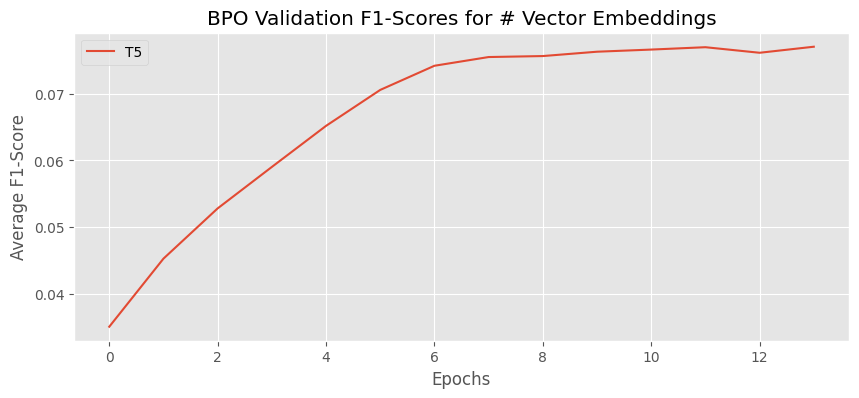

In [35]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_BPO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_BPO_losses["val"], label = "Concat")
plt.title("BPO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_BPO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_BPO_scores["val"], label = "Concat")
plt.title("BPO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## Make Predictions

In [36]:
model_map = {
    "CCO": {
        "T5": t5_CCO_model,
        # "ProtBERT": protbert_CCO_model,
        # "ESM2": esm2_CCO_model,
        # "Concat": cat_CCO_model,
        "labels": CCO_label_cols,
        "num_labels": CCO_num_labels,
    },
    "MFO": {
        "T5": t5_MFO_model,
        # "ProtBERT": protbert_MFO_model,
        # "ESM2": esm2_MFO_model,
        # "Concat": cat_MFO_model,
        "labels": MFO_label_cols,
        "num_labels": MFO_num_labels,
    },
    "BPO": {
        "T5": t5_BPO_model,
        # "ProtBERT": protbert_MFO_model,
        # "ESM2": esm2_MFO_model,
        # "Concat": cat_BPO_model,
        "labels": BPO_label_cols,
        "num_labels": BPO_num_labels,
    }
}

In [37]:
def predict(embeddings_source, subontology):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source, subontology=subontology)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = model_map[subontology][embeddings_source]
    label_cols = model_map[subontology]["labels"]
    num_labels = model_map[subontology]["num_labels"]

    model.eval()

    labels = pd.read_csv(CFG.train_terms_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = [label.split('_')[-1] for label in label_cols]
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(CFG.device)
        confs_[i*num_labels:(i+1)*num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*num_labels:(i+1)*num_labels] = id[0]
        go_terms_[i*num_labels:(i+1)*num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [38]:
CCO_submission_df = predict("T5", "CCO")
print(len(CCO_submission_df))
print(len(CCO_submission_df["GO term"].unique()))
CCO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


141865it [01:44, 1357.22it/s]


PREDICTIONS DONE
39296605
277


,Id,GO term,Confidence
0,Q9CQV8,GO:0000123,0.005222
1,Q9CQV8,GO:0000124,0.000012
2,Q9CQV8,GO:0000138,0.000035
3,Q9CQV8,GO:0000139,0.012969
4,Q9CQV8,GO:0000151,0.001312


In [39]:
MFO_submission_df = predict("T5", "MFO")
print(len(MFO_submission_df))
print(len(MFO_submission_df["GO term"].unique()))
MFO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


141865it [01:43, 1367.10it/s]


PREDICTIONS DONE
41992040
296


,Id,GO term,Confidence
0,Q9CQV8,GO:0000166,0.016901
1,Q9CQV8,GO:0000217,0.005717
2,Q9CQV8,GO:0000287,0.075451
3,Q9CQV8,GO:0000976,0.089018
4,Q9CQV8,GO:0000977,0.263827


In [40]:
BPO_submission_df = predict("T5", "BPO")
print(len(BPO_submission_df))
print(len(BPO_submission_df["GO term"].unique()))
BPO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


141865it [01:51, 1273.26it/s]


PREDICTIONS DONE
132076315
931


,Id,GO term,Confidence
0,Q9CQV8,GO:0000018,0.002079
1,Q9CQV8,GO:0000041,0.007161
2,Q9CQV8,GO:0000045,0.002551
3,Q9CQV8,GO:0000070,0.002508
4,Q9CQV8,GO:0000082,0.030452


In [41]:
# id_list = []
# go_term_list = []
# confidence_list = []
# for rw in CCO_submission_df.values:
#   edges = CCO_ordered_edges[rw[1]]
#   for edge in edges:
#     id_list.append(rw[0])
#     go_term_list.append(edge)
#     confidence_list.append(rw[2])
# additional_labels = pd.DataFrame({'Id': id_list, 'GO term': go_term_list, 'Confidence': confidence_list})

In [42]:
submission_df = pd.concat([CCO_submission_df, MFO_submission_df, BPO_submission_df,]).drop_duplicates(['Id', 'GO term']).reset_index(drop=True)

In [43]:
print(len(submission_df))  # 16546208
print(len(submission_df["GO term"].unique())) # 328
submission_df.head()

213363456
1504


,Id,GO term,Confidence
0,Q9CQV8,GO:0000123,0.005222
1,Q9CQV8,GO:0000124,0.000012
2,Q9CQV8,GO:0000138,0.000035
3,Q9CQV8,GO:0000139,0.012969
4,Q9CQV8,GO:0000151,0.001312


In [44]:
submission_df['Id'].unique()[:5]

array(['Q9CQV8', 'P62259', 'P68510', 'P61982', 'O70456'], dtype=object)

In [45]:
protein_id = 'P68510'
subset_df = submission_df[submission_df['Id'] == protein_id].reset_index(drop=True)

In [46]:
subset_df.loc[subset_df['Confidence'].argmax()]

Id                P68510
GO term       GO:0019904
Confidence      0.917055
Name: 477, dtype: object

In [47]:
subset_df.sort_values(['Confidence'], ascending=False).head(7)

,Id,GO term,Confidence
477,P68510,GO:0019904,0.917055
529,P68510,GO:0046982,0.882775
71,P68510,GO:0005829,0.871008
368,P68510,GO:0005515,0.866797
538,P68510,GO:0051117,0.862086
510,P68510,GO:0042802,0.848852
520,P68510,GO:0044325,0.845240


In [48]:
train_terms[(train_terms['EntryID'] == protein_id) & (train_terms['aspect'] == 'CCO')]

,EntryID,term,aspect,ia
4032360,P68510,GO:0005622,CCO,0.366945
4032361,P68510,GO:0060076,CCO,4.520144
4032362,P68510,GO:0014704,CCO,0.525320
4032363,P68510,GO:0044291,CCO,3.752804
4032364,P68510,GO:0005575,CCO,0.000000
4032365,P68510,GO:0098984,CCO,2.297752
4032366,P68510,GO:0098978,CCO,1.802445
4032367,P68510,GO:0032279,CCO,0.102393
4032368,P68510,GO:0005829,CCO,1.545978
4032369,P68510,GO:0150048,CCO,1.415037


In [55]:
submission_df['Confidence'] = np.round(submission_df['Confidence'], 3)
submission_df = submission_df[(submission_df['Confidence'] > 0.)]

In [49]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)

In [57]:
len(submission_df)

118041770

In [56]:
submission_df['Id'].value_counts()

P10400    1411
Q32KS0    1357
Q7SY06    1354
Q462R2    1350
Q9UKP3    1349
          ... 
P84386     156
Q36257     151
P84381     145
Q156A1     131
P84385     122
Name: Id, Length: 141864, dtype: int64